In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial import distance_matrix, KDTree
from scipy.sparse import bsr_array, diags
from scipy.sparse.linalg import expm, inv, eigs

from sklearn.datasets import make_swiss_roll

import copy

import mpl_toolkits.mplot3d.axes3d as p3
import sklearn.manifold as manifold
from sklearn.datasets import make_s_curve, make_swiss_roll
from sklearn.decomposition import PCA

import datafold.dynfold as dfold
import datafold.pcfold as pfold
from datafold.dynfold import LocalRegressionSelection
from datafold.utils.plot import plot_pairwise_eigenvector

from diffusion import diffusion_map, diff_plt

%load_ext autoreload
%autoreload 2

# Task 1 - Fourier Analysis

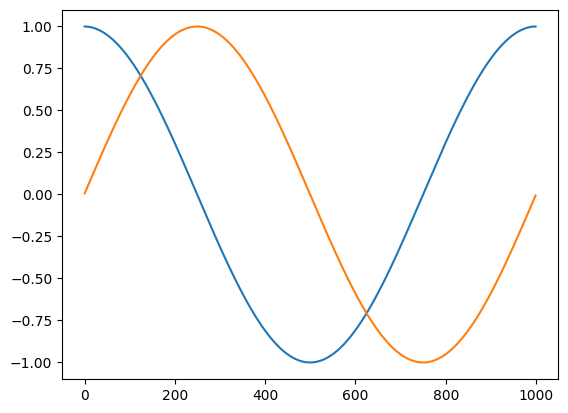

In [2]:
N = 1000
T = np.array([2*np.pi*k/(N+1) for k in range(1, N+1)])
X_Fourier = np.array((np.cos(T), np.sin(T))).T
plt.plot(X_Fourier)

In [15]:
lambdas_Fourier, vectors_Fourier = diffusion_map(X_Fourier, L=5)

Estimated data's diamater: 1.414


c:\Users\Averret\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


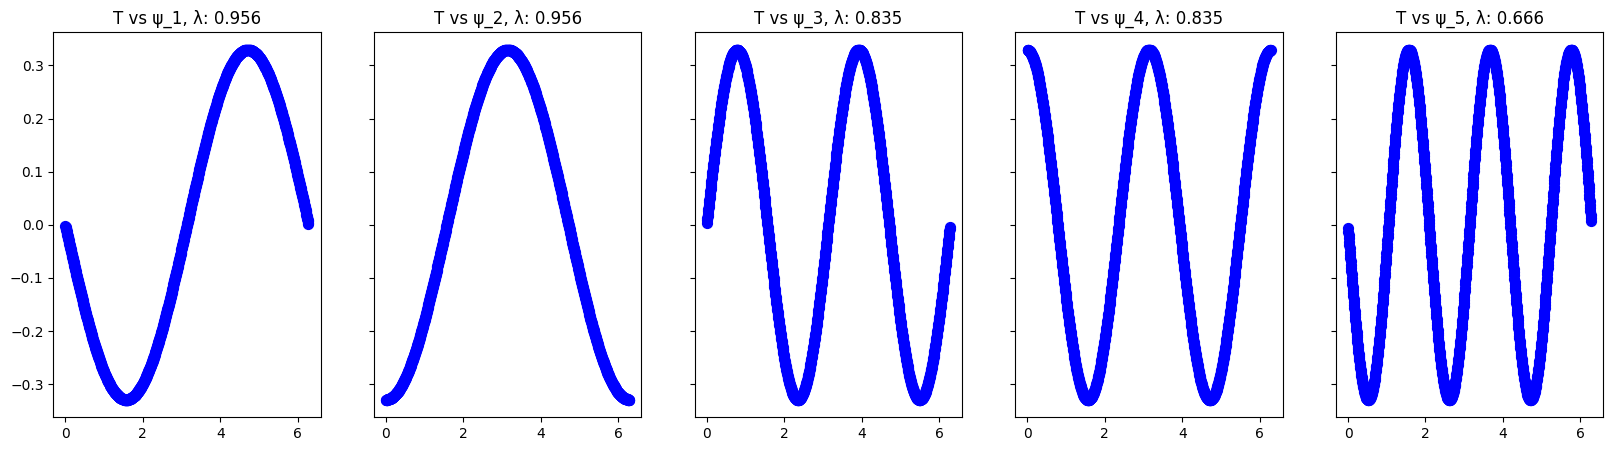

In [36]:
diff_plt(vectors_Fourier, lambdas_Fourier, T, 1, True)

# Task 2 - Swiss-roll dataset

In [148]:
X_roll, roll_color = make_swiss_roll(5000)
print(f"X shape: {X_roll.shape}, color shape: {roll_color.shape}")

X shape: (5000, 3), color shape: (5000,)


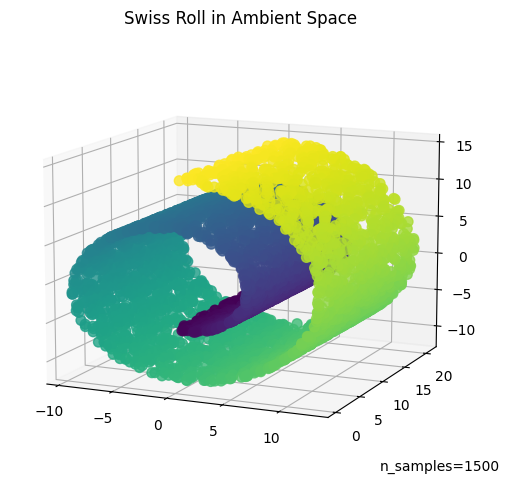

In [149]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    X_roll[:, 0], X_roll[:, 1], X_roll[:, 2], c=roll_color, s=50, alpha=0.8
)
ax.set_title("Swiss Roll in Ambient Space")
ax.view_init(azim=-66, elev=12)
_ = ax.text2D(0.8, 0.05, s="n_samples=1500", transform=ax.transAxes)

In [150]:
lambdas_roll, vectors_roll = diffusion_map(X_roll, L=11)

Estimated data's diamater: 36.372


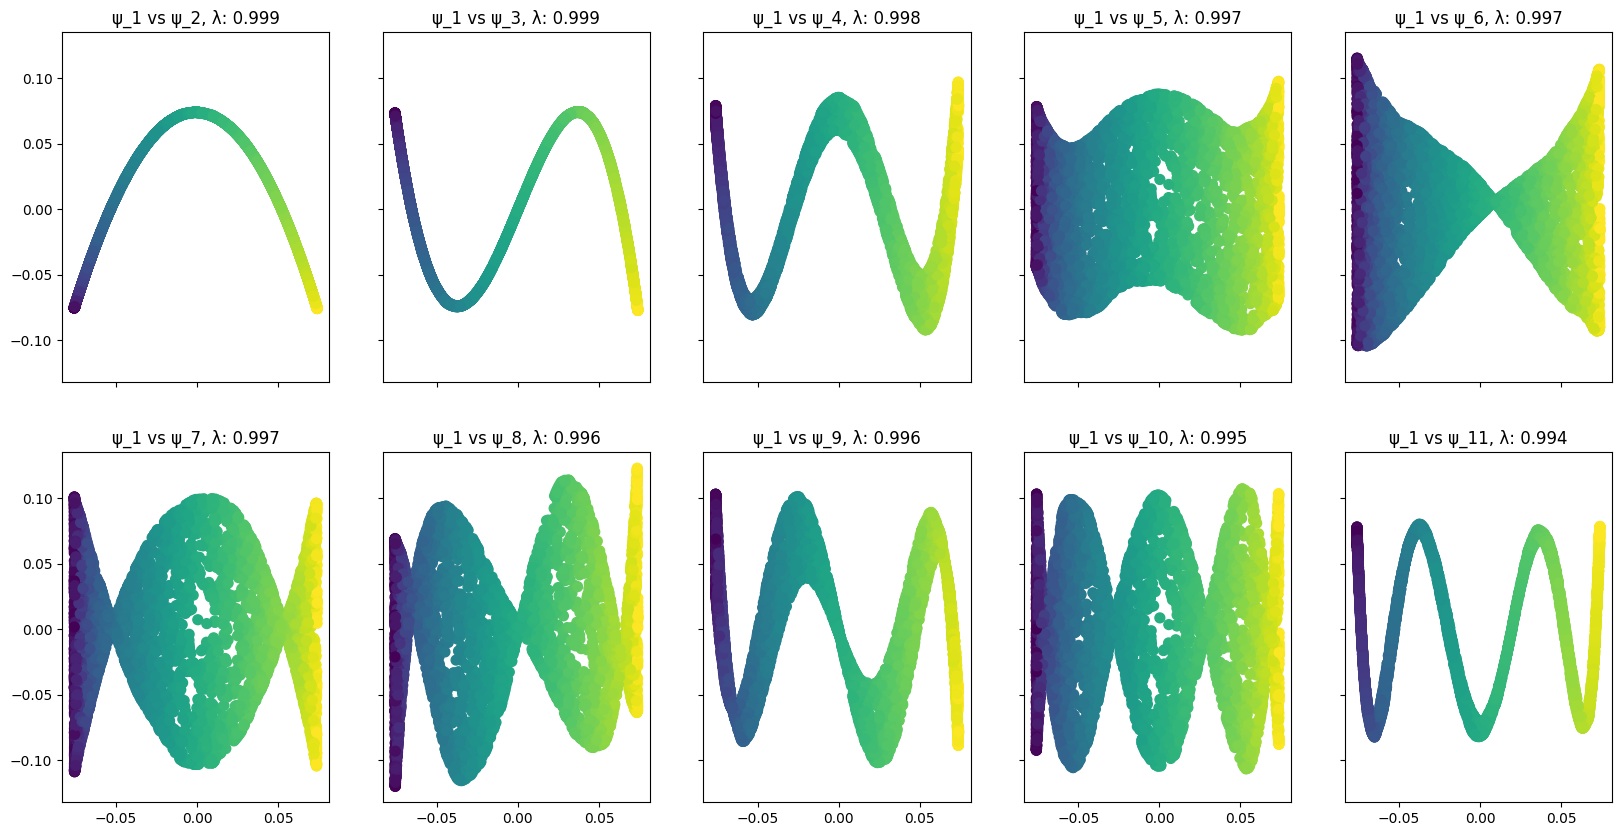

In [152]:
diff_plt(vectors_roll, lambdas_roll, vectors_roll[:, 1], 2, c=roll_color)

#### Task 2 - Using 1000 samples

Estimated data's diamater: 36.336


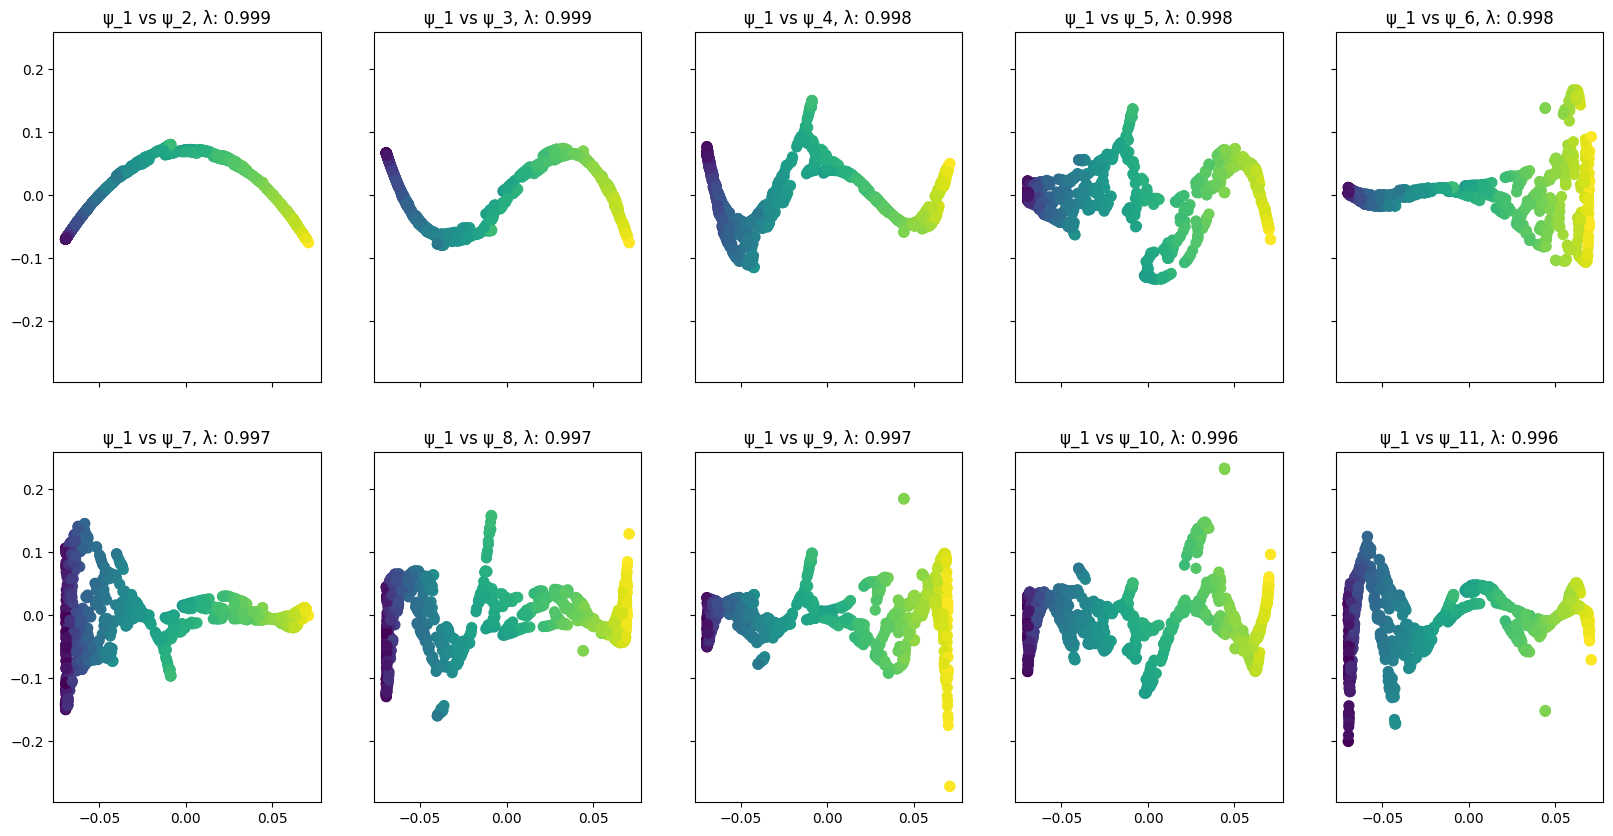

In [138]:
X_roll_1000, roll_color_1000 = make_swiss_roll(1000)
lambdas_roll_1000, vectors_roll_1000 = diffusion_map(X_roll_1000, L=11)
diff_plt(vectors_roll_1000, lambdas_roll_1000, vectors_roll_1000[:, 1], 2, c=roll_color_1000)

# Task 3 - Pedestrians paths

In [116]:
with open("./data_DMAP_PCA_vadere.txt") as f:
  X_paths = np.loadtxt(f, delimiter=' ')
X_paths.shape

(1000, 30)

In [121]:
lambdas_paths, vectors_paths = diffusion_map(X_paths, L=11)

Estimated data's diamater: 137.379


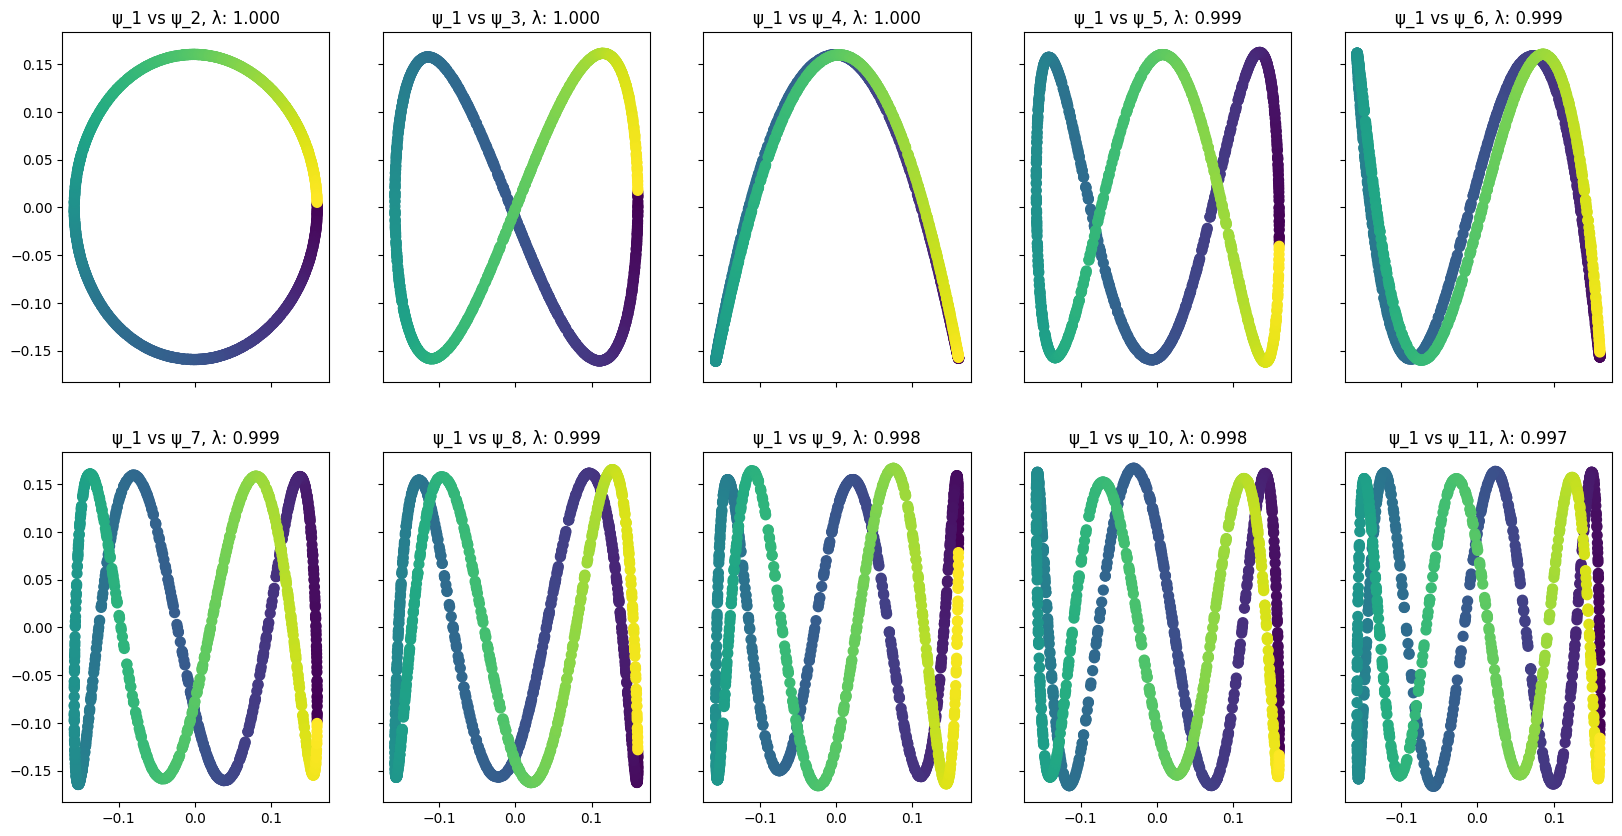

In [122]:
diff_plt(vectors_paths, lambdas_paths, vectors_paths[:, 1], 2, c=np.linspace(0, 10, 1000))

#### Task 3 - Using datafold 

In [94]:
X_pcm = pfold.PCManifold(X_paths)
X_pcm.optimize_parameters()

print(f"epsilon={X_pcm.kernel.epsilon}, cut-off={X_pcm.cut_off}")

epsilon=1.1889188145294278, cut-off=4.67981772219014


In [130]:
nr_samples_plot = 1000
idx_plot = np.random.permutation(1000)[0:nr_samples_plot]

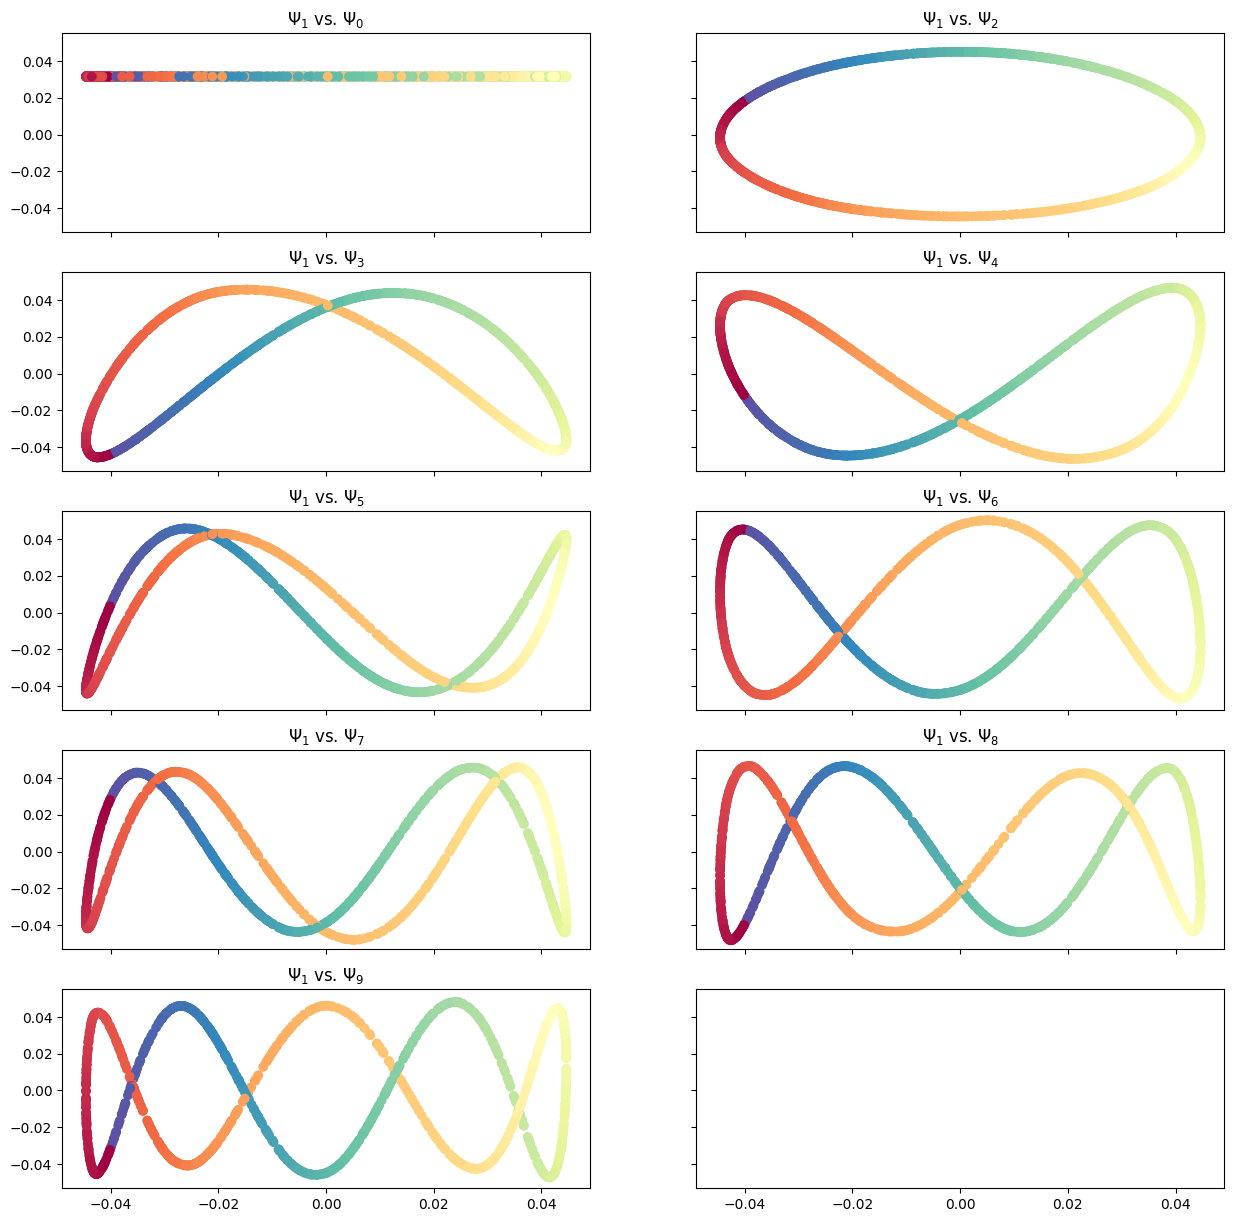

In [131]:
dmap = dfold.DiffusionMaps(
    kernel=pfold.GaussianKernel(epsilon=X_pcm.kernel.epsilon),
    n_eigenpairs=10,
    dist_kwargs=dict(cut_off=X_pcm.cut_off),
)
dmap = dmap.fit(X_pcm)
evecs, evals = dmap.eigenvectors_, dmap.eigenvalues_

plot_pairwise_eigenvector(
    eigenvectors=dmap.eigenvectors_[idx_plot, :],
    n=1,
    fig_params=dict(figsize=[15, 15]),
    scatter_params=dict(cmap=plt.cm.Spectral, c=np.linspace(0, 10, 1000)[idx_plot]),
)

In [133]:
selection = LocalRegressionSelection(
    intrinsic_dim=2, n_subsample=1000, strategy="dim"
).fit(dmap.eigenvectors_)
print(f"Found parsimonious eigenvectors (indices): {selection.evec_indices_}")
print(selection.residuals_)

Found parsimonious eigenvectors (indices): [1 2]
[       nan 1.         0.98211482 0.20088886 0.33029908 0.22996734
 0.32682628 0.24518035 0.28200004 0.2503131 ]


# Bonus Task

In [139]:
X_pcm = pfold.PCManifold(X_roll)
X_pcm.optimize_parameters()

print(f"epsilon={X_pcm.kernel.epsilon}, cut-off={X_pcm.cut_off}")

epsilon=0.724687000243714, cut-off=3.6536595176318754


In [140]:
nr_samples_plot = 1000
idx_plot = np.random.permutation(1000)[0:nr_samples_plot]

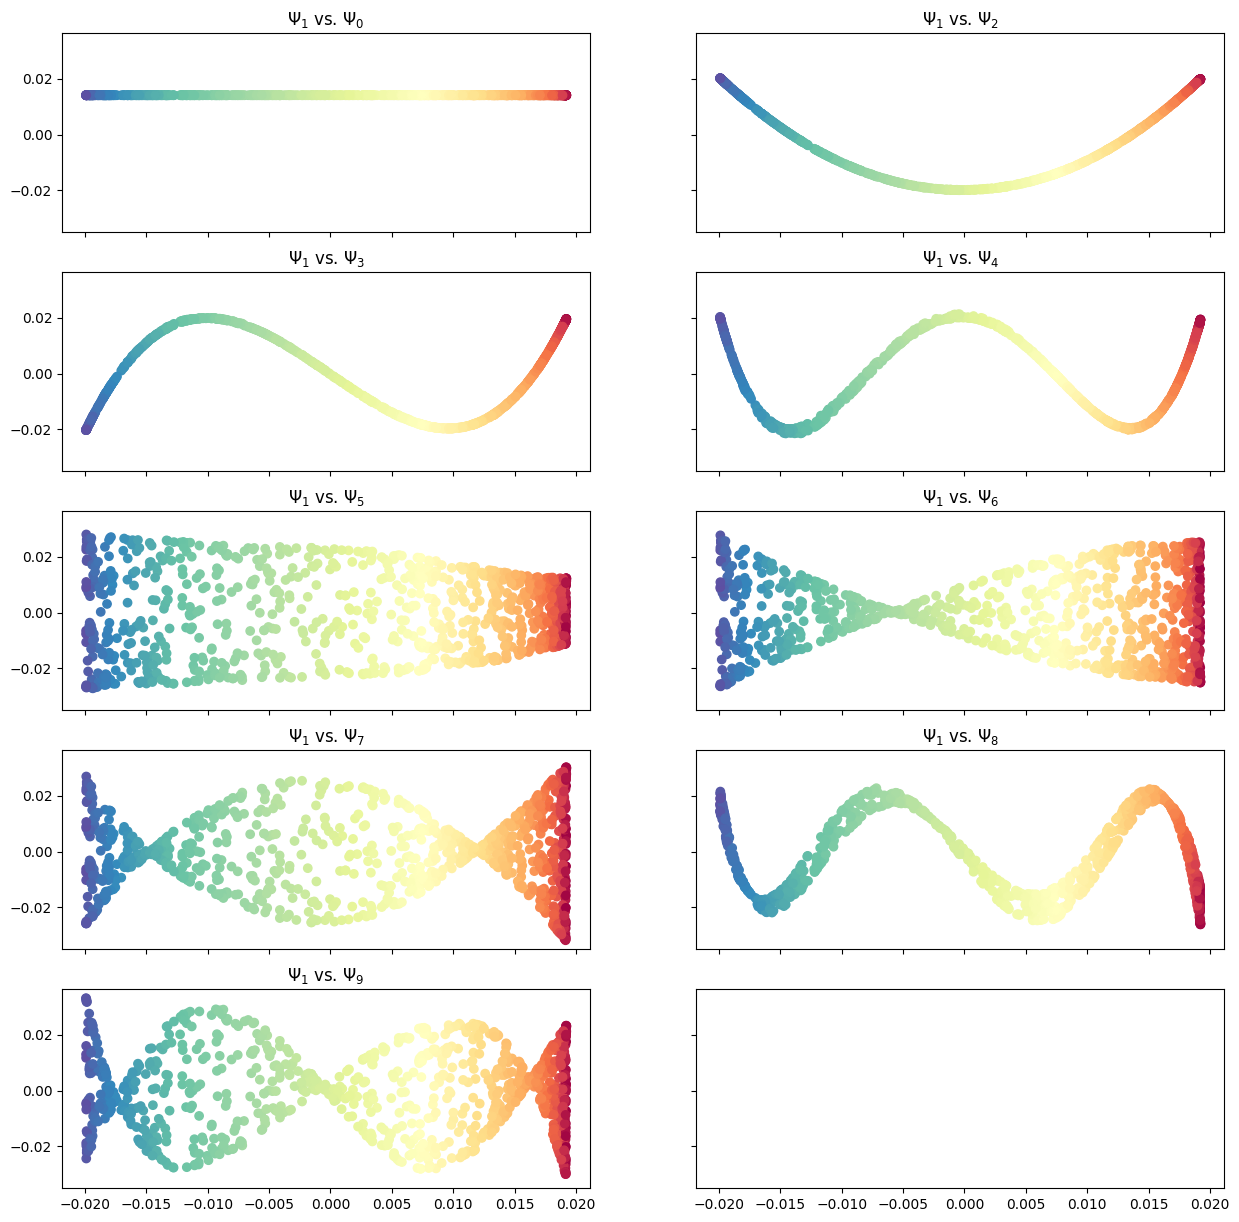

In [142]:
dmap = dfold.DiffusionMaps(
    kernel=pfold.GaussianKernel(epsilon=X_pcm.kernel.epsilon),
    n_eigenpairs=10,
    dist_kwargs=dict(cut_off=X_pcm.cut_off),
)
dmap = dmap.fit(X_pcm)
evecs, evals = dmap.eigenvectors_, dmap.eigenvalues_

plot_pairwise_eigenvector(
    eigenvectors=dmap.eigenvectors_[idx_plot, :],
    n=1,
    fig_params=dict(figsize=[15, 15]),
    scatter_params=dict(cmap=plt.cm.Spectral, c=roll_color[idx_plot]),
)

In [144]:
selection = LocalRegressionSelection(
    intrinsic_dim=3, n_subsample=5000, strategy="dim"
).fit(dmap.eigenvectors_)
print(f"Found parsimonious eigenvectors (indices): {selection.evec_indices_}")
print(selection.residuals_)

Found parsimonious eigenvectors (indices): [1 5 8]
[       nan 1.         0.16044937 0.21686438 0.27395043 0.99616699
 0.18862708 0.11079387 0.35496479 0.12925938]
